<a href="https://colab.research.google.com/github/Mitochondrion3000/telegram-chat-analyzer/blob/main/Our_History_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Как экспортировать историю чата

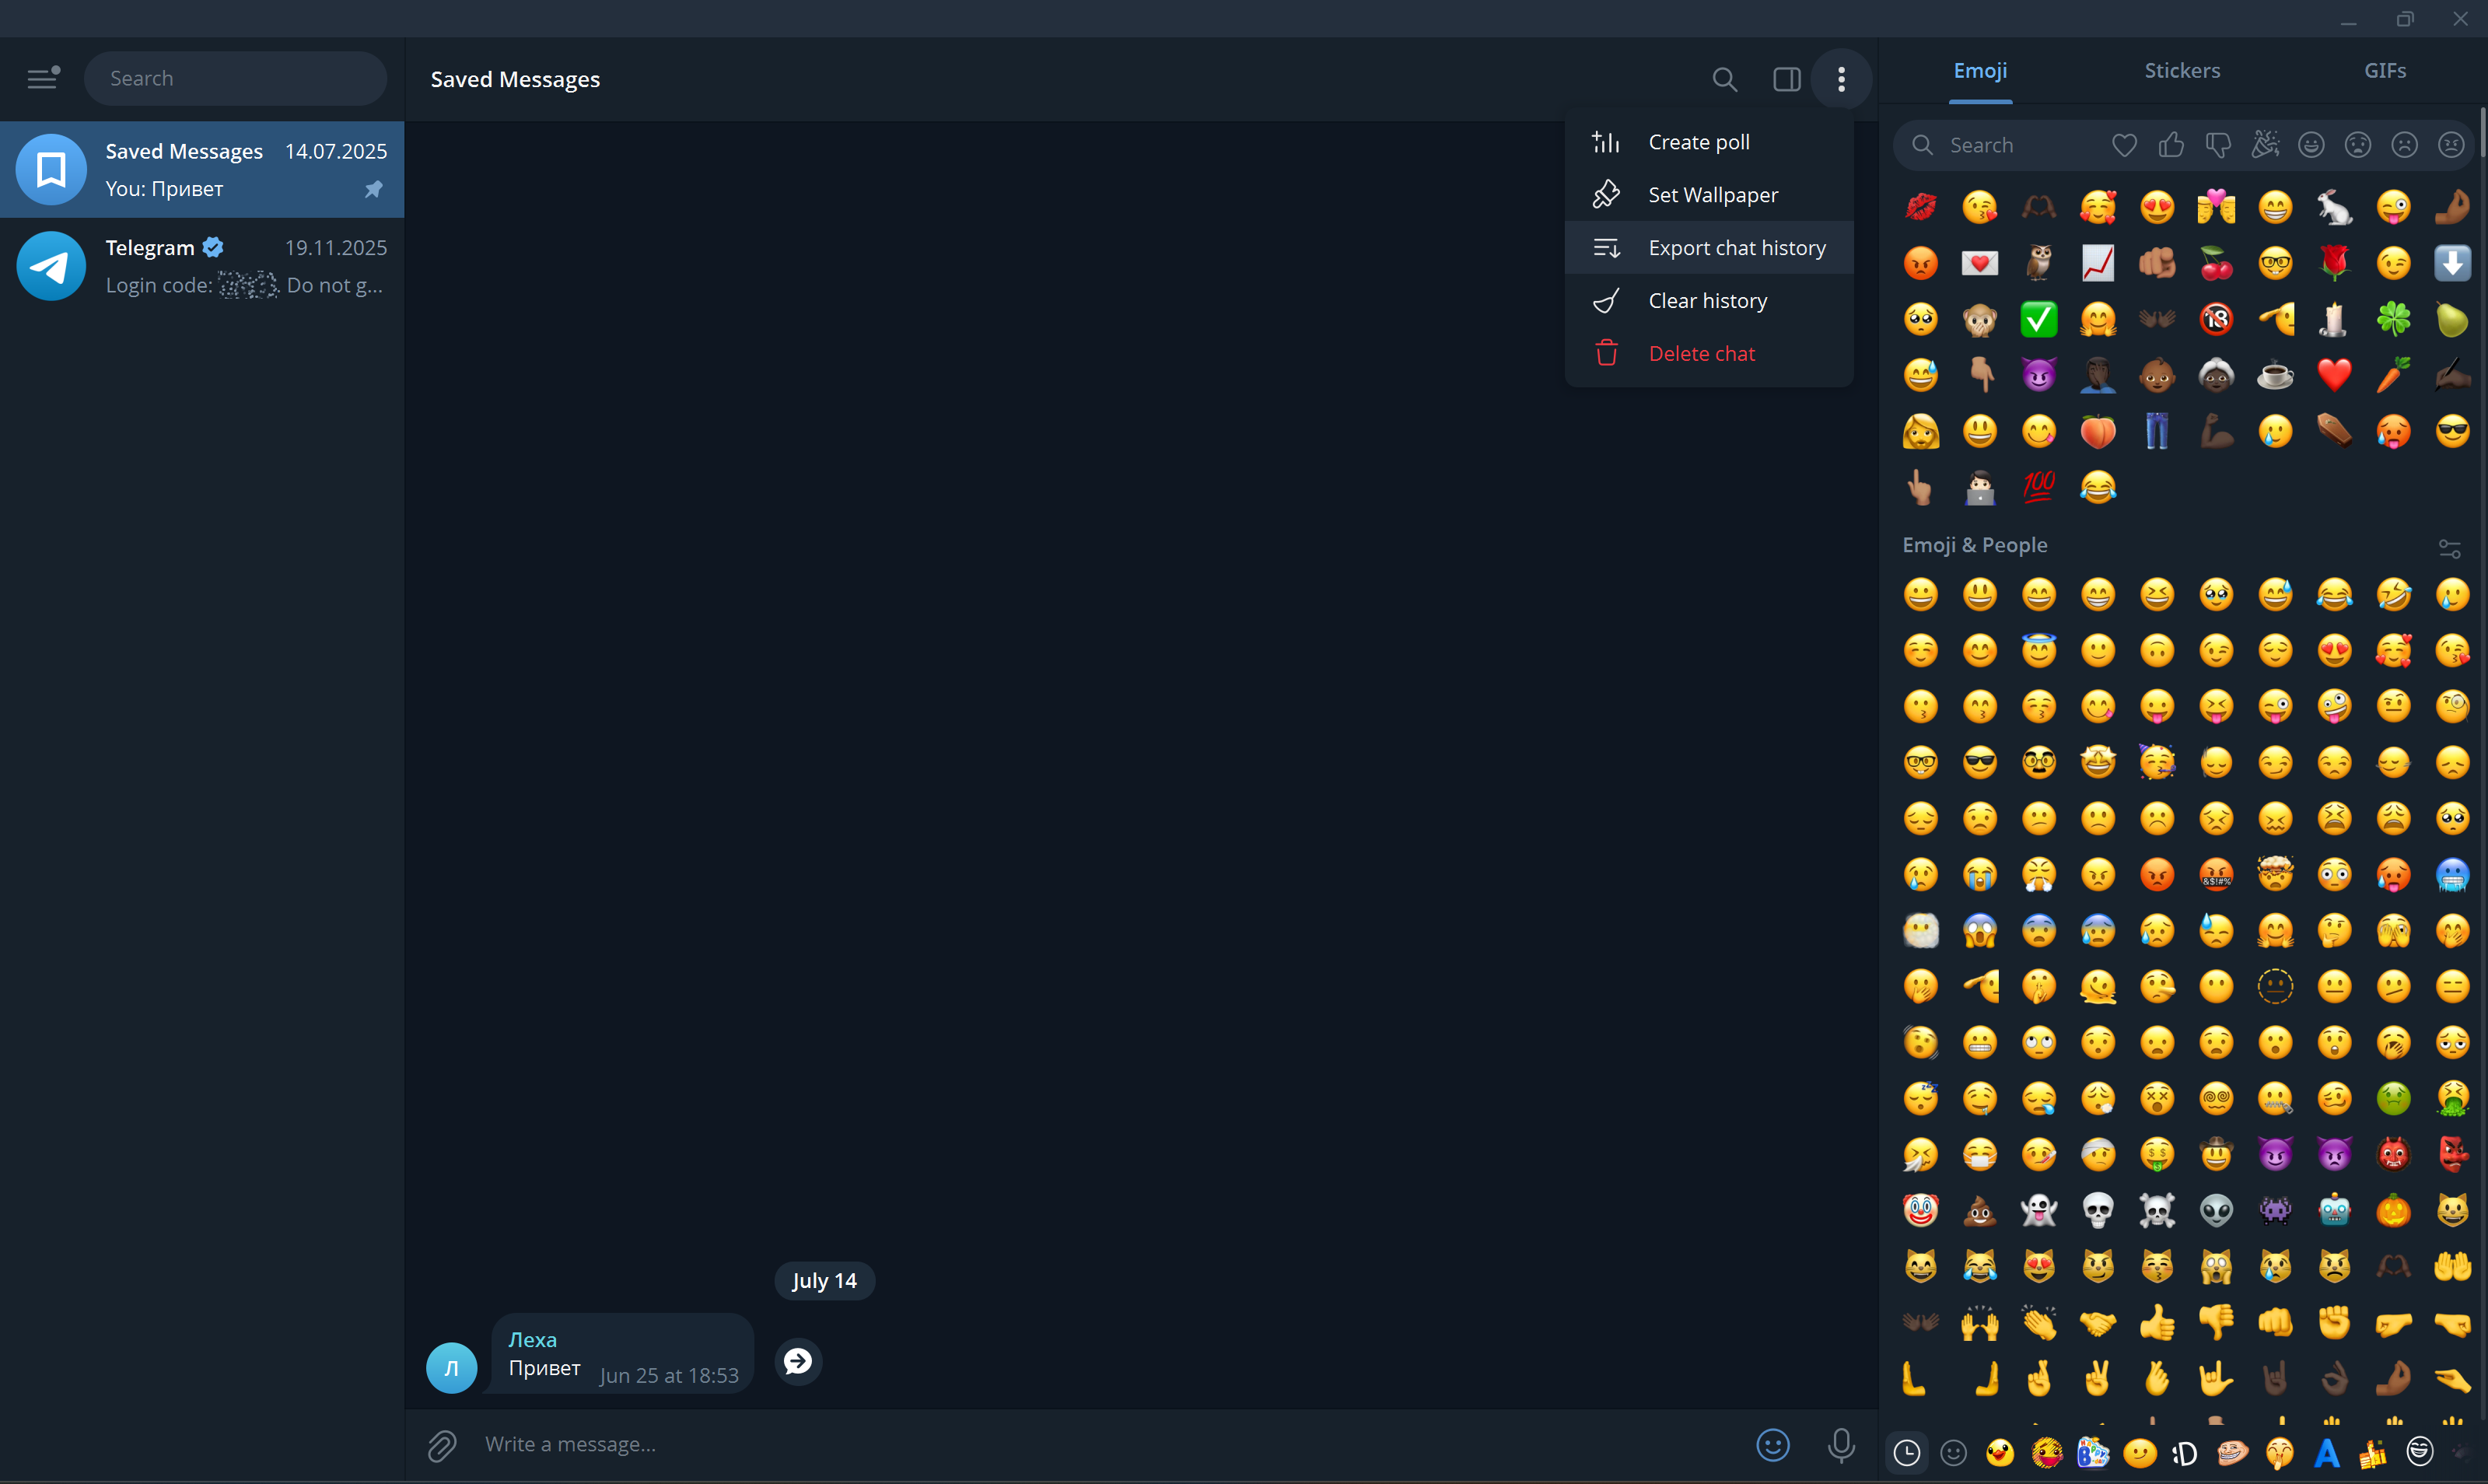

ОТкрывается это окошечко, убираем галочку с офтографий, ставим лимит(ползунок подальше)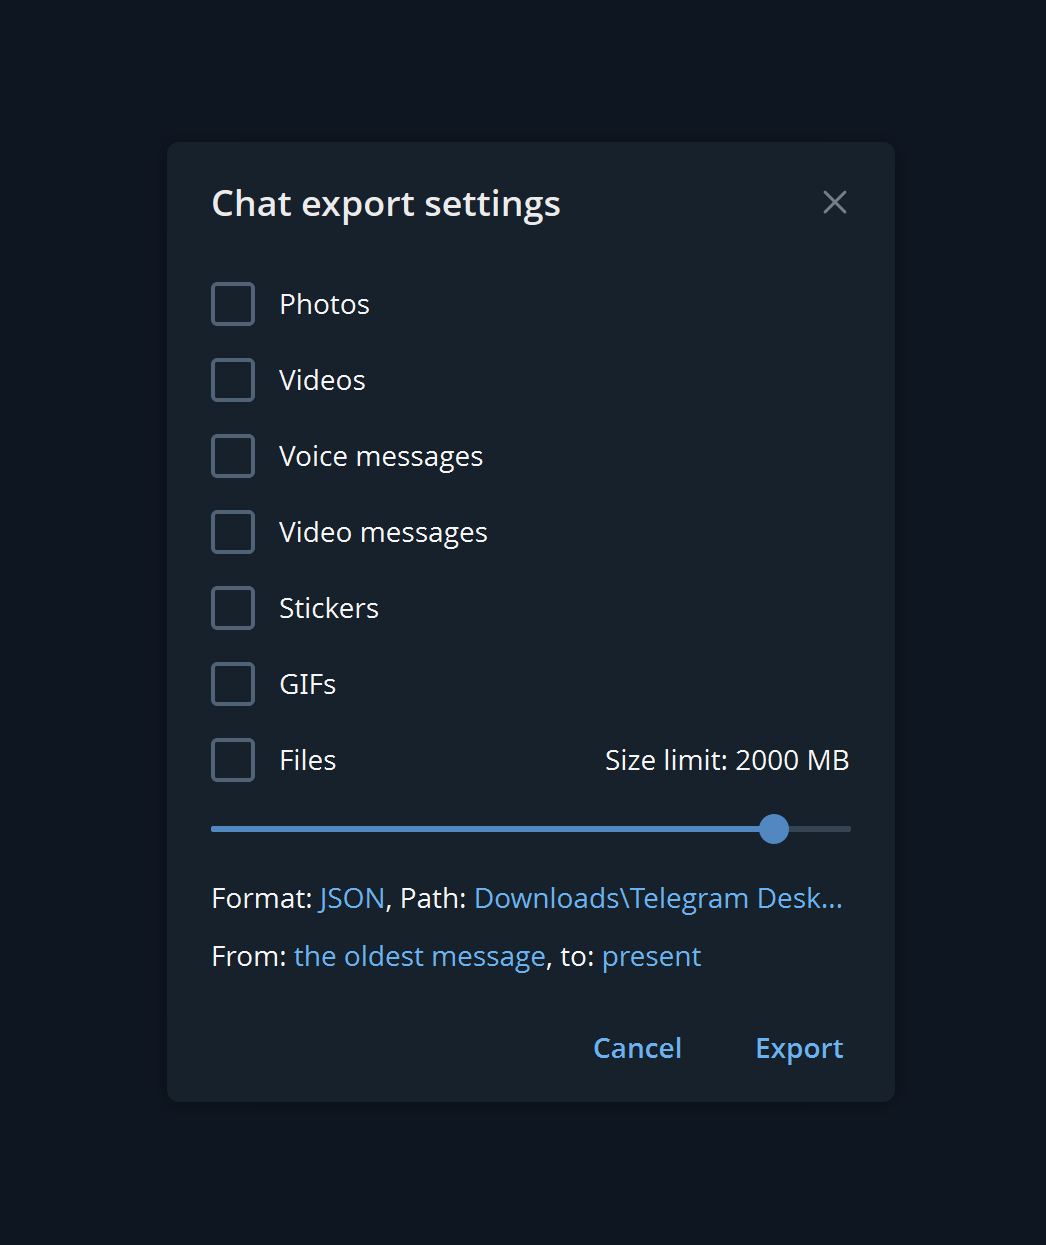

И выбираем формат и путь, нам нужен json 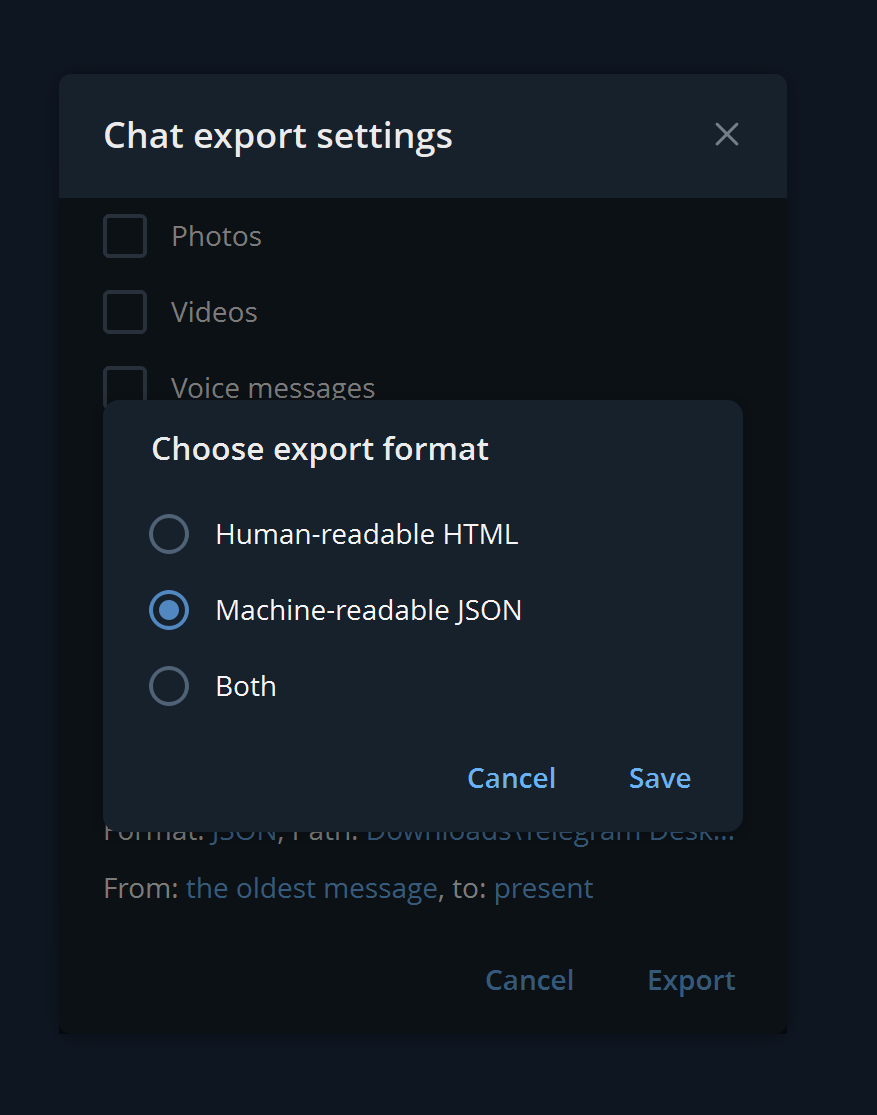

In [ ]:
# Установка необходимых библиотек (если запускаешь в Colab/Jupyter)
!pip install pandas matplotlib seaborn wordcloud emoji nltk scikit-learn

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from datetime import timedelta
from sklearn.feature_extraction.text import CountVectorizer

# Настройка стиля графиков для профессионального вида
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.mode.chained_assignment = None  # Убираем предупреждения pandas

# Загружаем стоп-слова для очистки текста
nltk.download('stopwords', quiet=True)
russian_stopwords = stopwords.words('russian')
# Добавляем мусорные слова, типичные для переписок
custom_stop_words = [
    'это', 'тебе', 'меня', 'просто', 'ну', 'да', 'нет', 'на', 'по', 'со',
    'из', 'от', 'до', 'за', 'над', 'под', 'об', 'во', 'уже', 'еще', 'ещё',
    'всё', 'все', 'весь', 'всю', 'то', 'же', 'ли', 'бы', 'или', 'ни', 'но',
    'а', 'и', 'в', 'к', 'с', 'о', 'у', 'ща', 'щас', 'сейчас', 'короче',
    'типа', 'вообще', 'ваще', 'вроде', 'кстати', 'реально', 'блин', 'привет',
    'пока', 'как', 'что', 'где', 'зачем', 'почему', 'че', 'чё'
]
STOP_WORDS = list(set(russian_stopwords + custom_stop_words))

print("✅ Библиотеки загружены и настроены.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.2 MB/s eta 0:00:00
✅ Библиотеки загружены и настроены.


In [ ]:
filepath = 'result.json'  # Убедись, что файл лежит рядом или укажи полный путь

def load_and_repair_json(path):
    """Читает файл, и если JSON битый — пытается восстановить сообщения вручную."""
    with open(path, 'r', encoding='utf-8') as f:
        raw_text = f.read()

    try:
        data = json.loads(raw_text)
        print("✅ Файл валидный, загружаем стандартно.")
        return data
    except json.JSONDecodeError:
        print("⚠️ JSON поврежден. Запускаем алгоритм восстановления...")

    # Алгоритм спасения данных (ищет объекты сообщений внутри текста)
    start_idx = raw_text.find('"messages": [')
    if start_idx == -1: return {"messages": []}

    content = raw_text[start_idx + 13:].strip() # Отрезаем начало
    recovered_msgs = []
    buffer = []
    brace_count = 0

    for char in content:
        if char == '{': brace_count += 1
        elif char == '}': brace_count -= 1
        buffer.append(char)

        if brace_count == 0 and buffer:
            msg_str = "".join(buffer).strip().strip(',')
            if msg_str:
                try:
                    obj = json.loads(msg_str)
                    if obj.get('type') == 'message':
                        recovered_msgs.append(obj)
                except: pass
            buffer = []

    print(f"🔧 Восстановлено {len(recovered_msgs)} сообщений.")
    return {"name": "Recovered Chat", "messages": recovered_msgs}

# Загружаем
raw_data = load_and_repair_json(filepath)

✅ Файл валидный, загружаем стандартно.


In [ ]:
# --- ЯЧЕЙКА 3: ОБРАБОТКА ДАННЫХ (ОБНОВЛЕННАЯ) ---
import re

messages = raw_data.get('messages', [])
clean_data = []

for msg in messages:
    if msg['type'] != 'message': continue

    # 1. Сборка текста
    text_content = ""
    val = msg.get('text', '')
    if isinstance(val, str): text_content = val
    elif isinstance(val, list):
        for part in val:
            if isinstance(part, str): text_content += part
            elif isinstance(part, dict): text_content += part.get('text', '')

    # 2. Определение типов медиа
    media_type = msg.get('media_type', '')

    # Голосовые
    is_voice = 1 if media_type == 'voice_message' else 0
    voice_sec = msg.get('duration_seconds', 0) if is_voice else 0

    # Видео (обычные файлы + кружочки)
    is_video = 1 if media_type in ['video_file', 'video_message', 'round_video_message'] else 0

    # Фото (обычно поле 'photo' есть в объекте, если это картинка)
    is_photo = 1 if 'photo' in msg else 0

    # 3. Подсчет слов (используем регулярку для точности)
    words = re.findall(r'\w+', text_content)

    row = {
        'date': msg['date'],
        'from': msg.get('from', 'Unknown'),
        'text': text_content,
        'msg_len': len(text_content),
        'word_count': len(words),          # Новое: кол-во слов
        'voice_count': is_voice,           # Новое: кол-во голосовых
        'voice_duration': voice_sec,       # Новое: длительность голосовых
        'video_count': is_video,           # Новое: кол-во видео
        'photo_count': is_photo,           # Новое: кол-во фото
        'has_sticker': 1 if 'sticker_emoji' in msg else 0
    }
    clean_data.append(row)

df = pd.DataFrame(clean_data)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Метрики времени (те же, что и раньше)
df['prev_date'] = df['date'].shift(1)
df['prev_from'] = df['from'].shift(1)
df['delta_sec'] = (df['date'] - df['prev_date']).dt.total_seconds()
is_reply = (df['from'] != df['prev_from']) & (df['delta_sec'] < 43200)
df.loc[is_reply, 'reply_time'] = df['delta_sec']
df['is_starter'] = (df['delta_sec'] > 21600) | (df['prev_date'].isna())

# Добавляем дни недели и часы
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.day_name()

print(f"📊 Обновленный DataFrame готов: {len(df)} строк.")
df.head()

📊 Обновленный DataFrame готов: 5449 строк.


date           from                        text  msg_len  \
0 2025-02-04 20:03:34  Ivan Mikhniuk  Лол пригласили на демо дец       26   
1 2025-02-04 20:04:12  Ivan Mikhniuk                                    0   
2 2025-02-04 23:33:23  Ivan Mikhniuk             не богато фоток       15   
3 2025-02-04 23:33:24  Ivan Mikhniuk                                    0   
4 2025-02-04 23:33:24  Ivan Mikhniuk                                    0   

   word_count  voice_count  voice_duration  video_count  photo_count  \
0           5            0               0            0            0   
1           0            0               0            0            1   
2           3            0               0            0            0   
3           0            0               0            0            1   
4           0            0               0            0            1   

   has_sticker           prev_date      prev_from  delta_sec  reply_time  \
0            0                 NaT           None        NaN         NaN   
1            0 2025-02-04 20:03:34  Ivan Mikhniuk       38.0         NaN   
2            0 2025-02-04 20:04:12  Ivan Mikhniuk    12551.0         NaN   
3            0 2025-02-04 23:33:23  Ivan Mikhniuk        1.0         NaN   
4            0 2025-02-04 23:33:24  Ivan Mikhniuk        0.0         NaN   

   is_starter  hour  weekday  
0        True    20  Tuesday  
1       False    20  Tuesday  
2       False    23  Tuesday  
3       False    23  Tuesday  
4       False    23  Tuesday

/tmp/ipython-input-1810871457.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats, x='User', y=col_name, palette=palette, ax=ax)
/tmp/ipython-input-1810871457.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats, x='User', y=col_name, palette=palette, ax=ax)
/tmp/ipython-input-1810871457.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats, x='User', y=col_name, palette=palette, ax=ax)
/tmp/ipython-input-1810871457.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

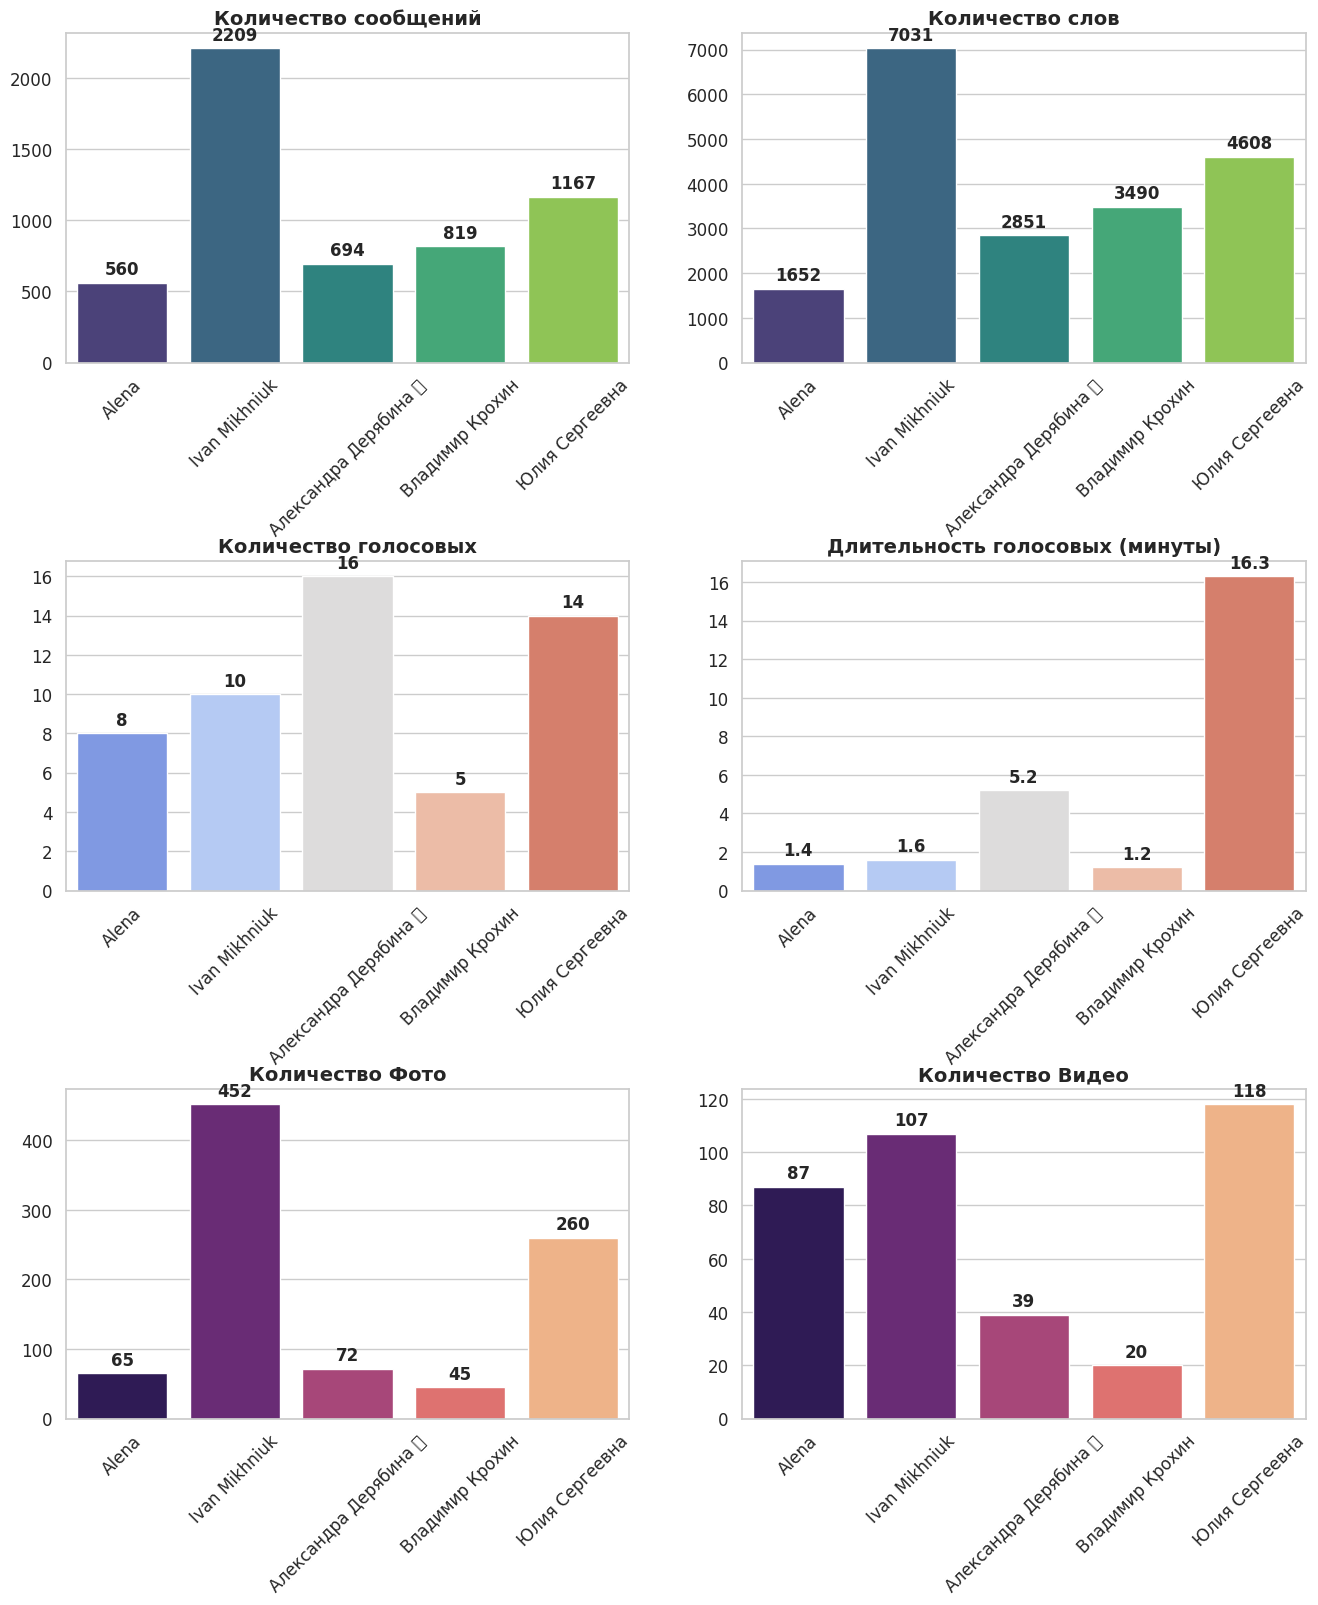

📝 Детальная статистика:


User  Messages  Words  Chats Started  Photos  Videos  \
0                  Alena       560   1652             37      65      87   
1          Ivan Mikhniuk      2209   7031             99     452     107   
2  Александра Дерябина 🐚       694   2851             20      72      39   
3        Владимир Крохин       819   3490             29      45      20   
4         Юлия Сергеевна      1167   4608             64     260     118   

   Voice Count  Voice Min  
0            8        1.4  
1           10        1.6  
2           16        5.2  
3            5        1.2  
4           14       16.3

In [ ]:
# --- ЯЧЕЙКА 4: СТАТИСТИКА И ГРАФИКИ (ОБНОВЛЕННАЯ) ---

# 1. Агрегация данных
stats = df.groupby('from').agg({
    'text': 'count',               # Всего сообщений
    'word_count': 'sum',           # Всего слов
    'is_starter': 'sum',           # Инициатива
    'voice_count': 'sum',          # Кол-во голосовых
    'voice_duration': 'sum',       # Длительность голосовых (сек)
    'photo_count': 'sum',          # Кол-во фото
    'video_count': 'sum'           # Кол-во видео
}).reset_index()

# Переводим секунды в минуты для удобства
stats['voice_duration_min'] = (stats['voice_duration'] / 60).round(1)

# Переименование для красоты
stats.columns = [
    'User', 'Messages', 'Words', 'Chats Started',
    'Voice Count', 'Voice Sec', 'Photos', 'Videos', 'Voice Min'
]

# 2. Настройка визуализации (3 ряда графиков)
fig, axes = plt.subplots(3, 2, figsize=(16, 18)) # Сетка 3x2
# Увеличил hspace с 0.4 до 0.6, чтобы поместились наклонные подписи
plt.subplots_adjust(hspace=0.6)

# Список метрик для отрисовки
metrics = [
    ('Messages', 'Количество сообщений', 'viridis', axes[0, 0]),
    ('Words', 'Количество слов', 'viridis', axes[0, 1]),

    ('Voice Count', 'Количество голосовых', 'coolwarm', axes[1, 0]),
    ('Voice Min', 'Длительность голосовых (минуты)', 'coolwarm', axes[1, 1]),

    ('Photos', 'Количество Фото', 'magma', axes[2, 0]),
    ('Videos', 'Количество Видео', 'magma', axes[2, 1])
]

# Цикл построения графиков
for col_name, title, palette, ax in metrics:
    sns.barplot(data=stats, x='User', y=col_name, palette=palette, ax=ax)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

    # --- ИЗМЕНЕНИЕ: Поворот подписей на 45 градусов ---
    ax.tick_params(axis='x', rotation=45)

    # Добавляем цифры над столбцами
    # padding=3 немного приподнимает цифру над столбцом
    for container in ax.containers:
        ax.bar_label(container, fmt='%g', padding=3, fontsize=12, fontweight='bold')

plt.show()

# 3. Вывод детальной таблицы
print("📝 Детальная статистика:")
# Выбираем нужные колонки для отображения
display_cols = ['User', 'Messages', 'Words', 'Chats Started', 'Photos', 'Videos', 'Voice Count', 'Voice Min']
display(stats[display_cols])

/tmp/ipython-input-659398900.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=resp_df, x='from', y='reply_min', palette="Pastel1", showfliers=False)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128026 (\N{SPIRAL SHELL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


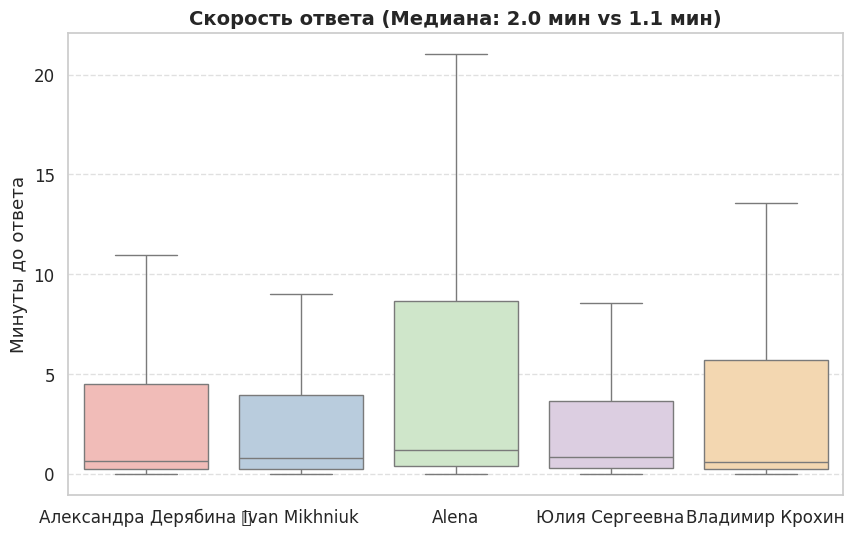

In [ ]:
# Фильтруем данные: берем только ответы и убираем экстремальные выбросы (для красоты графика)
# Берем 90-й перцентиль, чтобы график не сплющивался из-за ответов через 3 дня
cutoff = df['reply_time'].quantile(0.90)
resp_df = df[(df['reply_time'].notna()) & (df['reply_time'] < cutoff)].copy()

# Переводим секунды в минуты
resp_df['reply_min'] = resp_df['reply_time'] / 60

plt.figure(figsize=(10, 6))
sns.boxplot(data=resp_df, x='from', y='reply_min', palette="Pastel1", showfliers=False)

# Считаем медиану для заголовка
medians = df.groupby('from')['reply_time'].median() / 60
title_text = f"Скорость ответа (Медиана: {medians.iloc[0]:.1f} мин vs {medians.iloc[1]:.1f} мин)"

plt.title(title_text, fontsize=14, fontweight='bold')
plt.ylabel('Минуты до ответа')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

/tmp/ipython-input-1321541566.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=starter_stats, x='from', y='Starts Count', palette='magma')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128026 (\N{SPIRAL SHELL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


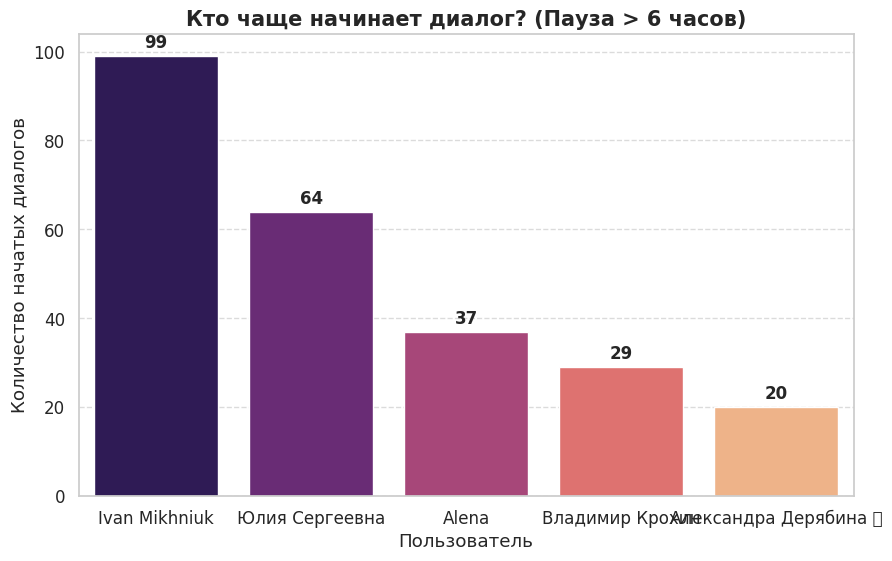

📊 Всего новых сессий общения: 249
🚀 Ivan Mikhniuk: начал диалог 99 раз (39.8%)
🚀 Юлия Сергеевна: начал диалог 64 раз (25.7%)
🚀 Alena: начал диалог 37 раз (14.9%)
🚀 Владимир Крохин: начал диалог 29 раз (11.6%)
🚀 Александра Дерябина 🐚: начал диалог 20 раз (8.0%)


In [ ]:
# Рассчитываем количество инициаций для каждого пользователя
starter_stats = df[df['is_starter'] == True].groupby('from').size().reset_index(name='Starts Count')
starter_stats = starter_stats.sort_values(by='Starts Count', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=starter_stats, x='from', y='Starts Count', palette='magma')

# Добавляем цифры над столбцами
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=12, fontweight='bold')

plt.title('Кто чаще начинает диалог? (Пауза > 6 часов)', fontsize=15, fontweight='bold')
plt.xlabel('Пользователь')
plt.ylabel('Количество начатых диалогов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Текстовый вывод
total_starts = starter_stats['Starts Count'].sum()
print(f"📊 Всего новых сессий общения: {total_starts}")
for _, row in starter_stats.iterrows():
    percent = (row['Starts Count'] / total_starts) * 100
    print(f"🚀 {row['from']}: начал диалог {row['Starts Count']} раз ({percent:.1f}%)")

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


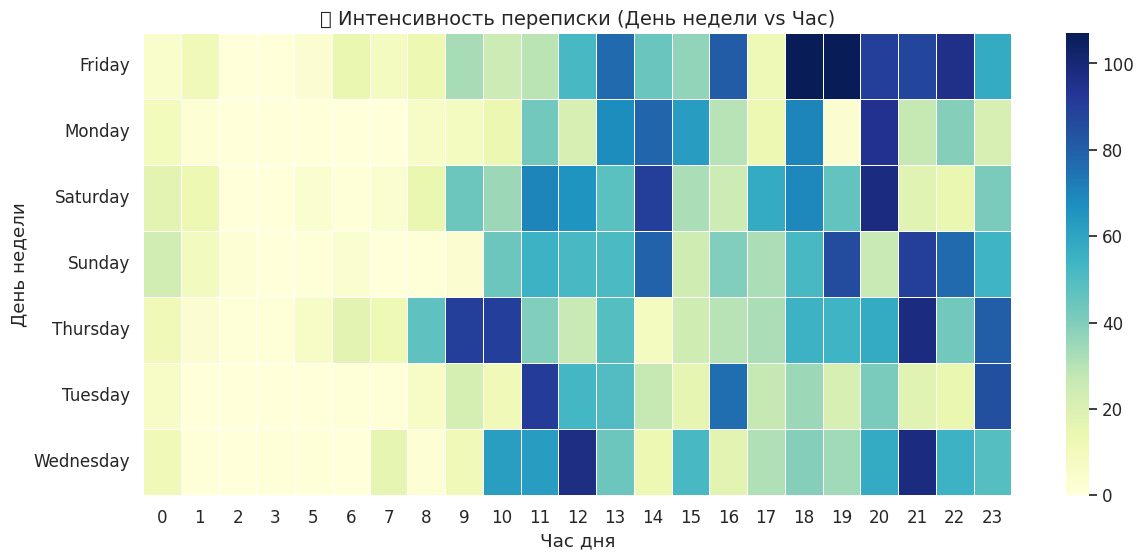

In [ ]:
# Создаем сводную таблицу (pivot)
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", linewidths=.5)
plt.title('🔥 Интенсивность переписки (День недели vs Час)', fontsize=14)
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.yticks(rotation=0)
plt.show()

/tmp/ipython-input-1624175255.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="viridis")
/tmp/ipython-input-1624175255.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="viridis")
/tmp/ipython-input-1624175255.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="viridis")
/tmp/ipython-input-1624175255.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

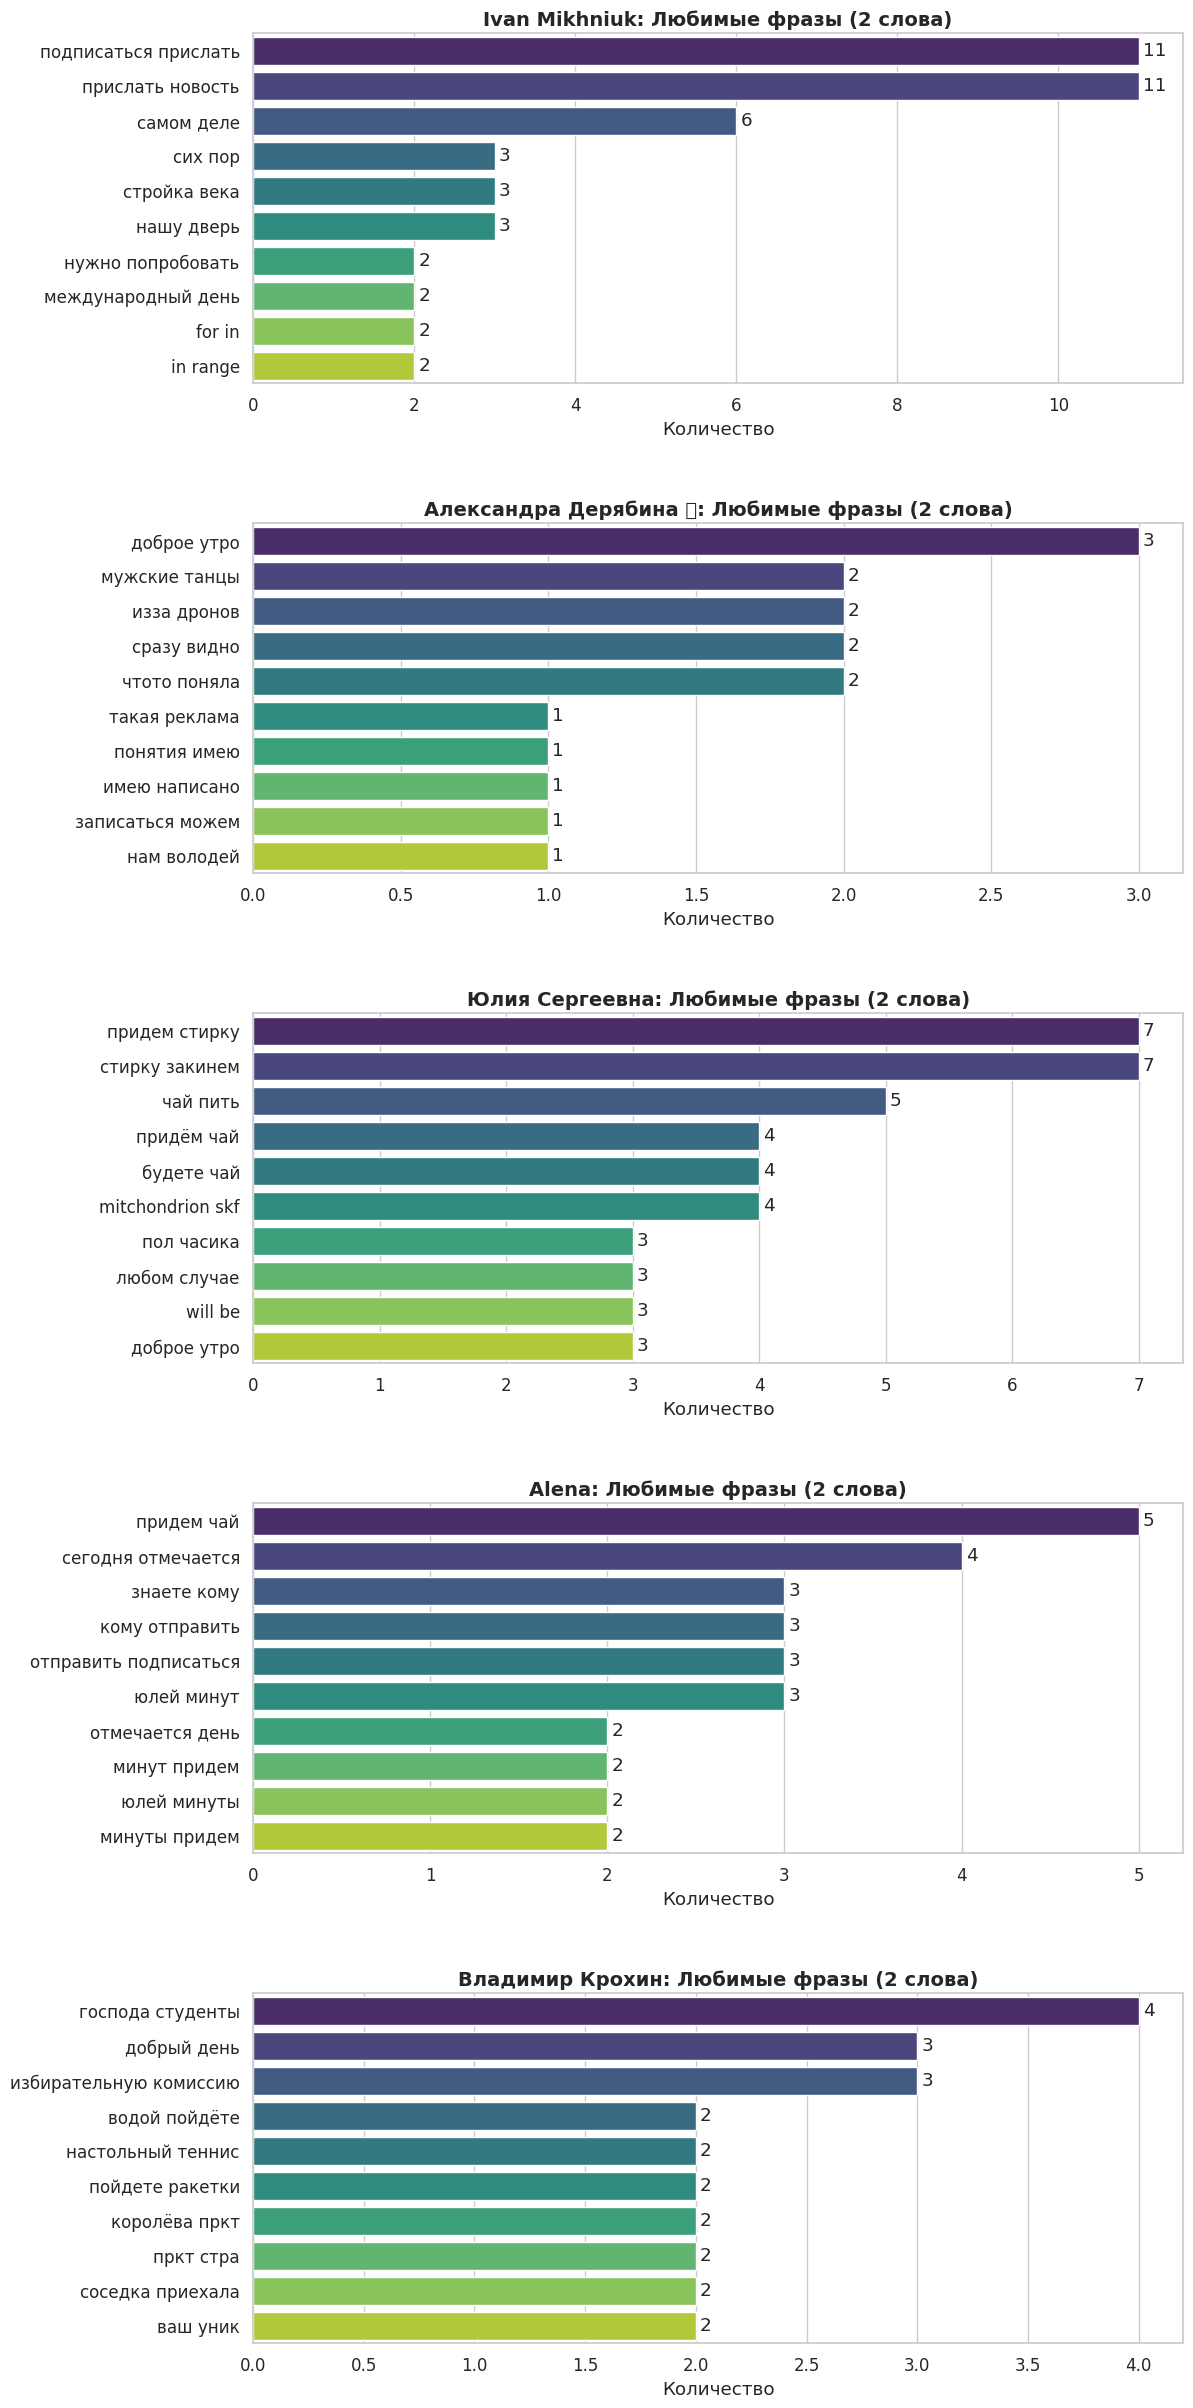

In [ ]:
def plot_top_ngrams(df, ngram_range=(2, 2), top_k=10, title="Биграммы"):
    users = df['from'].unique()

    # --- ИЗМЕНЕНИЕ 1: Вертикальная сетка ---
    # nrows=len(users), ncols=1 (один столбец, много строк)
    # figsize=(10, 5 * len(users)) — высота зависит от количества людей
    fig, axes = plt.subplots(len(users), 1, figsize=(12, 6 * len(users)))

    # Если пользователь один, axes не список, превращаем в список
    if len(users) == 1:
        axes = [axes]

    # Функция очистки
    def clean_text(text):
        text = re.sub(r'http\S+', '', str(text).lower())
        text = re.sub(r'[^а-яёa-z\s]', '', text)
        return text

    df['clean_text'] = df['text'].apply(clean_text)

    for i, user in enumerate(users):
        user_text = df[df['from'] == user]['clean_text'].dropna()
        user_text = user_text[user_text.str.len() > 0]

        if len(user_text) == 0:
            continue

        # Векторизация
        vec = CountVectorizer(ngram_range=ngram_range, stop_words=STOP_WORDS)
        try:
            bag_of_words = vec.fit_transform(user_text)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

            # Отрисовка
            x_vals = [x[1] for x in words_freq]
            y_vals = [x[0] for x in words_freq]

            sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="viridis")

            axes[i].set_title(f"{user}: {title}", fontsize=14, fontweight='bold')
            axes[i].set_xlabel("Количество")

            # Добавляем цифры справа от баров, чтобы было наглядно
            for container in axes[i].containers:
                axes[i].bar_label(container, padding=3)

        except ValueError:
            print(f"У {user} недостаточно данных для {title}")

    # --- ИЗМЕНЕНИЕ 2: Отступы между графиками по вертикали ---
    # hspace=0.4 дает пространство между графиком сверху и заголовком снизу
    plt.subplots_adjust(hspace=0.4)

    plt.show()

# Запускаем
plot_top_ngrams(df, ngram_range=(2, 2), title="Любимые фразы (2 слова)")

/tmp/ipython-input-3804938453.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="plasma")
/tmp/ipython-input-3804938453.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="plasma")
/tmp/ipython-input-3804938453.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="plasma")
/tmp/ipython-input-3804938453.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign

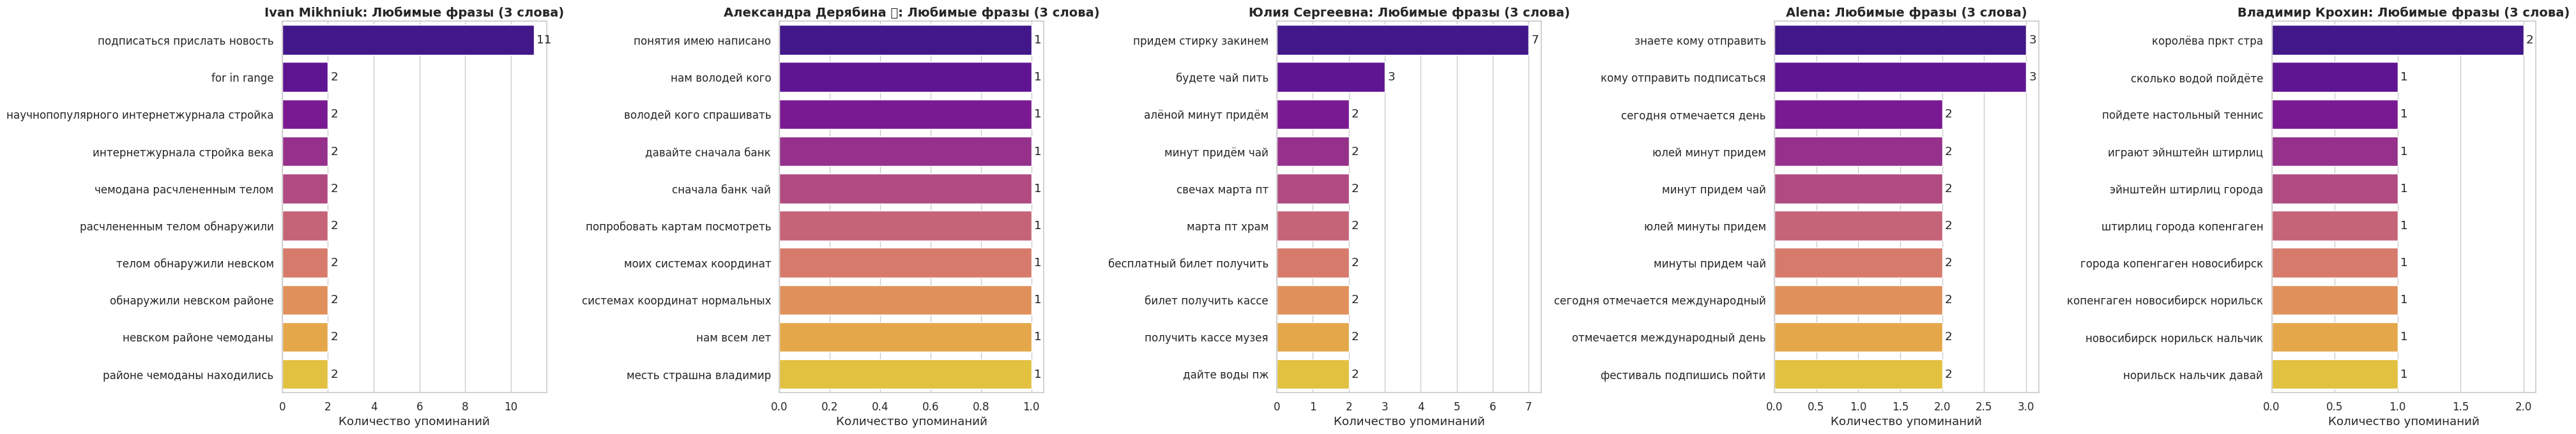

In [ ]:
# --- ЯЧЕЙКА: АНАЛИЗ ТРИГРАММ (3 СЛОВА) ---

def plot_top_trigrams(df, top_k=10):
    users = df['from'].unique()
    n_users = len(users)

    # Динамически настраиваем размер сетки
    fig, axes = plt.subplots(1, n_users, figsize=(8 * n_users, 7))

    # Если пользователь один, превращаем axes в список для итерации
    if n_users == 1:
        axes = [axes]

    # Внутренняя функция очистки (удаляем ссылки и не-буквы)
    def clean_text_local(text):
        text = re.sub(r'http\S+', '', str(text).lower())
        text = re.sub(r'[^а-яёa-z\s]', '', text)
        return text

    # Создаем временную колонку с очищенным текстом
    df['clean_text_trigram'] = df['text'].apply(clean_text_local)

    for i, user in enumerate(users):
        user_text = df[df['from'] == user]['clean_text_trigram'].dropna()
        # Исключаем слишком короткие сообщения, где не может быть 3 слов
        user_text = user_text[user_text.apply(lambda x: len(str(x).split()) >= 3)]

        if len(user_text) == 0:
            axes[i].text(0.5, 0.5, 'Недостаточно данных', ha='center')
            axes[i].set_title(f"{user}: Триграммы")
            continue

        # Векторизация (ngram_range=(3, 3) ищет именно тройки слов)
        vec = CountVectorizer(ngram_range=(3, 3), stop_words=STOP_WORDS)

        try:
            bag_of_words = vec.fit_transform(user_text)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

            if not words_freq:
                raise ValueError

            # Подготовка данных для графика
            y_vals = [x[0] for x in words_freq]
            x_vals = [x[1] for x in words_freq]

            # Отрисовка
            sns.barplot(x=x_vals, y=y_vals, ax=axes[i], palette="plasma")
            axes[i].set_title(f"{user}: Любимые фразы (3 слова)", fontsize=14, fontweight='bold')
            axes[i].set_xlabel("Количество упоминаний")
            axes[i].set_ylabel("")

            # Добавляем цифры над столбцами
            for container in axes[i].containers:
                axes[i].bar_label(container, fmt='%d', padding=3)

        except ValueError:
            axes[i].text(0.5, 0.5, 'Нет популярных фраз', ha='center')
            axes[i].set_title(f"{user}: Триграммы")

    plt.tight_layout()
    plt.show()

# Запускаем анализ
plot_top_trigrams(df, top_k=10)

In [ ]:
# --- ЯЧЕЙКА 8: ТОП ЭМОДЗИ (С ТЕКСТОВЫМ ОПИСАНИЕМ) ---
import plotly.express as px
import emoji
from collections import Counter

def plot_emoji_final(df):
    users = df['from'].unique()

    def extract_emojis(text):
        return [c for c in text if c in emoji.EMOJI_DATA]

    for user in users:
        user_text = "".join(df[df['from'] == user]['text'].astype(str))
        all_emojis = extract_emojis(user_text)

        if not all_emojis:
            print(f"У пользователя {user} нет эмодзи.")
            continue

        counts = Counter(all_emojis).most_common(10)

        # Создаем данные с описаниями
        data = []
        for emj, count in counts:
            # Получаем текстовое имя эмодзи (например, :heart:)
            demojized = emoji.demojize(emj).replace(':', '')
            data.append({
                'Emoji': emj,
                'Label': f"{emj} ({demojized})", # Комбинируем символ и текст
                'Count': count
            })

        emoji_df = pd.DataFrame(data)

        fig = px.bar(
            emoji_df,
            x='Count',
            y='Label',
            orientation='h',
            title=f"Топ эмодзи: {user} (символ + описание)",
            text='Count',
            color='Count',
            color_continuous_scale='Viridis'
        )

        fig.update_layout(
            template='plotly_white',
            yaxis=dict(
                tickfont=dict(size=14), # Уменьшили размер, так как теперь есть текст
                categoryorder='total ascending'
            ),
            xaxis_title="Количество упоминаний",
            yaxis_title="",
            margin=dict(l=200) # Увеличили отступ слева для длинных названий
        )

        fig.update_traces(textposition='outside')
        fig.show()

# Запускаем финальную версию
plot_emoji_final(df)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

def plot_pro_chronology(df):
    # 1. Группировка данных (Ежедневно)
    daily = df.groupby([pd.Grouper(key='date', freq='D'), 'from']).size().unstack(fill_value=0)
    daily['Total'] = daily.sum(axis=1)

    # Скользящее среднее для плавной линии тренда (за 7 дней)
    daily['Trend'] = daily['Total'].rolling(window=7, center=True).mean()

    users = [c for c in daily.columns if c not in ['Total', 'Trend']]

    # 2. Создание базового графика
    fig = go.Figure()

    # Добавляем столбцы для каждого пользователя
    colors = ['#2c5f85', '#32b37b']
    for i, user in enumerate(users):
        fig.add_trace(go.Bar(
            x=daily.index,
            y=daily[user],
            name=user,
            marker_color=colors[i % len(colors)],
            offsetgroup=0,
        ))

    # Добавляем линию тренда
    fig.add_trace(go.Scatter(
        x=daily.index,
        y=daily['Trend'],
        name='Тренд (7дн)',
        line=dict(color='#e74c3c', width=3, dash='dot'),
        hoverinfo='skip'
    ))

    # 3. Настройка периодов (Аннотации и выделение фона)
    events = [
        {'start': '2025-04-09', 'end': '2025-05-16', 'label': '📍 Вместе в Питере', 'color': 'rgba(44, 95, 133, 0.15)'},
        {'start': '2025-05-17', 'end': '2025-05-24', 'label': '🪖 Военная кафедра', 'color': 'rgba(231, 76, 60, 0.15)'},
        {'start': '2025-06-28', 'end': '2025-07-21', 'label': '📚 Сдаю экзамены', 'color': 'rgba(243, 156, 18, 0.15)'},
        {'start': '2025-08-07', 'end': '2025-09-01', 'label': '💔 Разлука до приезда в Минск', 'color': 'rgba(155, 89, 182, 0.15)'}
    ]

    for event in events:
        # Прямоугольник фона
        fig.add_vrect(
            x0=event['start'], x1=event['end'],
            fillcolor=event['color'], opacity=1, layer="below", line_width=0,
            annotation_text=event['label'],
            annotation_position="top left",
            annotation_font=dict(size=12, color="black", family="Arial Black")
        )

    # 4. Финальное оформление
    fig.update_layout(
        title=dict(text='📊 <b>Анализ динамики общения 2025</b>', x=0.5, font=dict(size=22)),
        barmode='stack',
        template='plotly_white',
        hovermode='x unified',
        xaxis=dict(
            title='Дата',
            rangeslider=dict(visible=True), # Добавляем ползунок снизу для навигации
            type='date',
            tickformat='%d %b'
        ),
        yaxis=dict(title='Количество сообщений'),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=700
    )

    fig.show()

# Запуск
plot_pro_chronology(df)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128026 (\N{SPIRAL SHELL}) missing from font(s) DejaVu Sans.



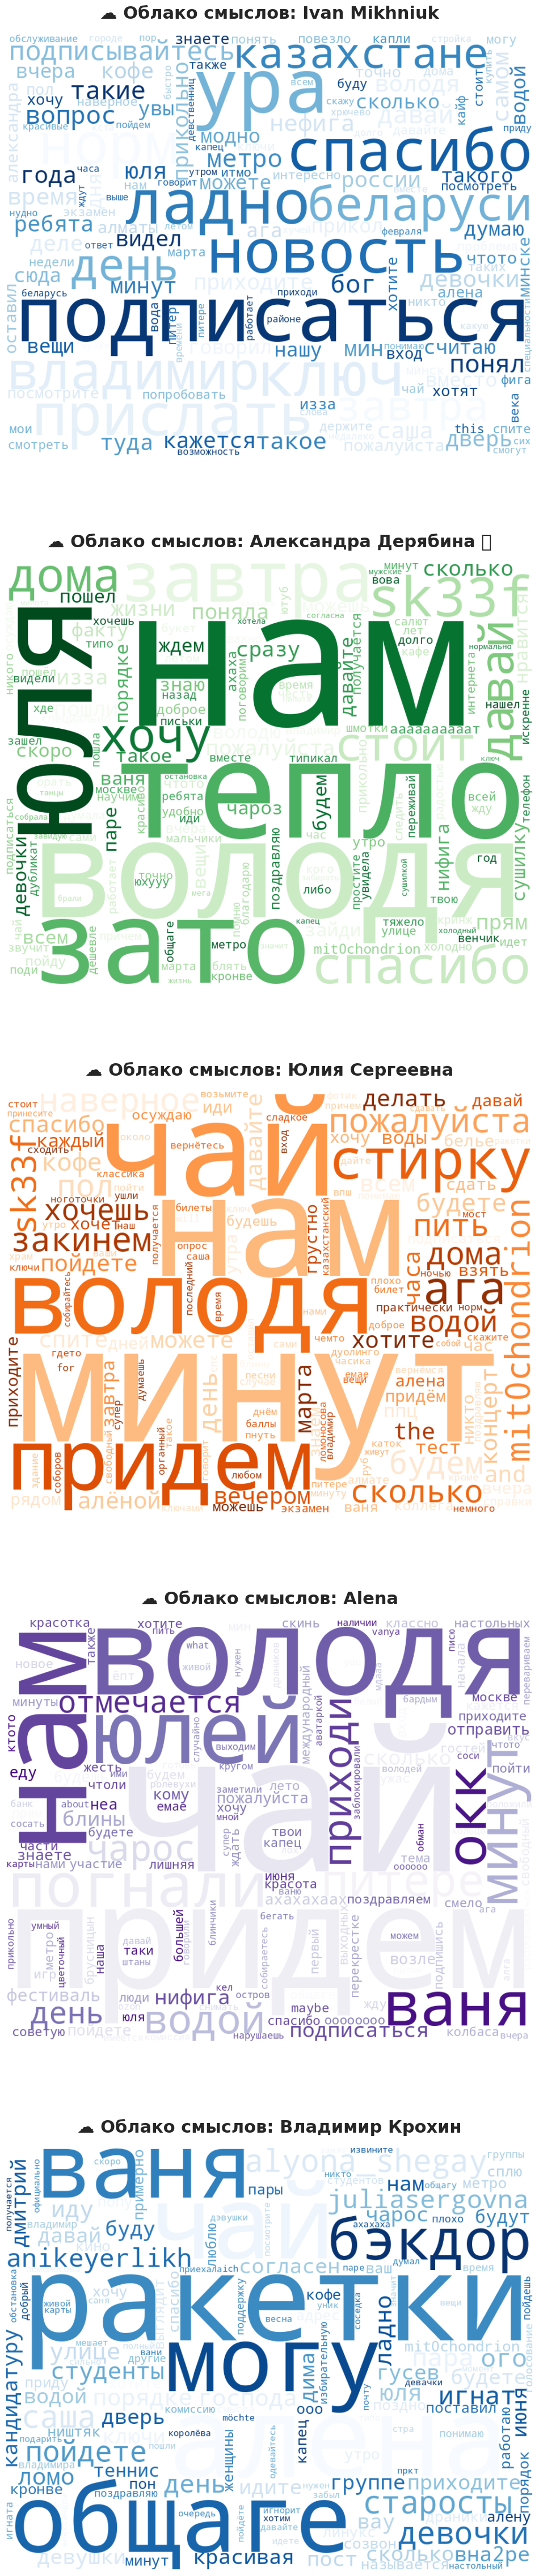

In [ ]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_pro_wordclouds(df):
    users = df['from'].unique()

    # Стоп-слова (проверка на существование глобальной переменной)
    base_stop_words = set(STOP_WORDS) if 'STOP_WORDS' in globals() else set()
    extra_garbage = {
        'который', 'свой', 'этот', 'хотеть', 'самый', 'вообще', 'типа',
        'просто', 'нужно', 'мочь', 'человек', 'сказать', 'думать', 'знать',
        'сообщение', 'фото', 'видео', 'файл', 'sticker', 'emoji', 'message',
        'очень', 'быть', 'если', 'когда', 'даже', 'только', 'сегодня'
    }
    final_stop_words = base_stop_words.union(extra_garbage)

    # --- ИЗМЕНЕНИЕ 1: Вертикальная сетка ---
    # nrows=len(users), ncols=1
    # Высоту (figsize) рассчитываем динамически: 10 дюймов на каждого человека
    fig, axes = plt.subplots(len(users), 1, figsize=(12, 10 * len(users)))

    # Если в чате только один человек, превращаем axes в список
    if len(users) == 1:
        axes = [axes]

    colormaps = ['Blues', 'Greens', 'Oranges', 'Purples']

    for i, user in enumerate(users):
        # 1. Сбор и очистка текста
        user_text = " ".join(df[df['from'] == user]['text'].astype(str).tolist())
        user_text = re.sub(r'http\S+|www\.\S+|[^\w\s]', '', user_text.lower())

        if not user_text.strip():
            axes[i].text(0.5, 0.5, f'Нет текста для {user}', ha='center', fontsize=16)
            axes[i].axis('off')
            continue

        # 2. Настройка WordCloud
        wc = WordCloud(
            width=1000,
            height=800, # Чуть уменьшил высоту пропорции, чтобы смотрелось широко
            background_color='white',
            colormap=colormaps[i % len(colormaps)],
            stopwords=final_stop_words,
            min_word_length=3,
            max_words=150,
            collocations=False
        ).generate(user_text)

        # 3. Отрисовка
        axes[i].imshow(wc, interpolation='bilinear')

        # Увеличил отступ заголовка (pad=20)
        axes[i].set_title(f'☁️ Облако смыслов: {user}', fontsize=22, fontweight='bold', pad=20)
        axes[i].axis('off')

    # --- ИЗМЕНЕНИЕ 2: Отступы ---
    # Убираем tight_layout и настраиваем отступы вручную через subplots_adjust
    # hspace=0.2 дает немного воздуха между картинками по вертикали
    plt.subplots_adjust(hspace=0.2, top=0.95, bottom=0.05)

    plt.show()

# Запуск
generate_pro_wordclouds(df)